In [1]:
import pathlib as pl

import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("colorblind"))

import itertools, warnings

from collections import Counter, defaultdict
from typing import List, Dict, Tuple

## Evaluating sentence-level differences between the different benchmarks


In this notebook, we will focus on trying to characterize the differences between the different benchmarks.
Before we delve into the analysis, let us define the properties we're interested in this work:
1. **words** that may (or not) be associated with gender, deemed *gender co-occurring words*; 
2. whether the **sentences are *neutral* or not**, irrespective of whether the words are associated with gender or not. We dub these sentences - *gender-invariant sentences*.


For 2., we have curated a set of prompts and conducted human evaluation to validate our claims. That is, we've characterized the distribution and showed that both pronouns fit. This validation verifies for our datasets as well as the coreference datasets, since they are created to be neutral by default.


We conjecture that by means of our prompts, the generated sentences are gender-invariant. Hence, this notebook will carry the evaluation for **1.**, i.e., as we vary the strength of association between gender and occurring words.

---


The remaining of the notebook is organized as follows: 

1. **Data loading**: we load both PMI difference values and the scores given by the models to each test sentence pair.
2. **Data analysis**: we evaluate how the benchmark size changes as we vary the strength of association between individual words and gender.
3. **Fairness metric**: we compute the fairness metric for the different models. This includes computing both the fairness metric to a fixed threshold and the AUC. 
4. **Fairness metric 2.0**: since our fairness metric focuses on the pct of "neutral" models, we aim to quantify whether the models are placing the remaining probability equally on male-female examples or whether they mostly place the probabilities on one instantiation of the templates.

## 1. Data Loading: Load PMI difference values

In [2]:
from utils import GROUP_PAIRED_WORDLIST, FEMALE_WORDS, MALE_WORDS

In [3]:
BASE_DIR = "/extra/ucinlp1/cbelem/projects/bias-diagnosis"

# loads the PMI information precomputed based on the PILE co-occurrence counts
GENDER_PMI = pd.read_csv(f"{BASE_DIR}/word2gender_pmi_PILE.csv", index_col=0)
print(len(GENDER_PMI))
GENDER_PMI.describe()

152515


,pmi__her,pmi__his,pmi__him,pmi__hers,pmi__mother,pmi__father,pmi__mom,pmi__dad,pmi__mummy,pmi__daddy,...,pmi__queen,pmi__king,pmi__queens,pmi__kings,pmi__princess,pmi__prince,pmi__princesses,pmi__princes,pmi__he,pmi__she
count,80439.000000,98771.000000,65608.000000,7537.000000,30706.000000,29684.000000,10998.000000,10495.000000,1717.000000,2977.000000,...,10119.000000,19446.000000,3313.000000,6617.000000,5412.000000,8203.000000,1266.000000,3825.000000,100828.000000,66891.000000
mean,-24.827642,-24.861843,-24.803681,-24.205257,-24.915487,-24.912725,-25.195694,-25.311220,-24.439117,-25.298108,...,-25.361834,-25.395301,-24.835216,-24.729553,-25.019586,-25.328138,-23.698000,-23.932025,-25.416424,-25.262707
std,1.563299,1.580690,1.506580,1.445382,1.324532,1.342077,1.403486,1.310585,1.538892,1.450787,...,1.435780,1.500407,1.723579,1.696653,1.477100,1.462137,1.718849,1.715749,1.514534,1.499545
min,-33.499275,-33.331670,-33.613325,-30.640672,-30.936595,-30.878193,-30.376505,-30.894450,-29.312282,-30.237593,...,-30.485745,-31.237119,-28.636829,-29.793686,-30.302262,-31.337065,-30.067307,-29.995963,-32.885207,-33.474327
25%,-25.685422,-25.682861,-25.638325,-25.184315,-25.755291,-25.742207,-26.175983,-26.204275,-25.419204,-26.245775,...,-26.331394,-26.407824,-25.942235,-25.915272,-26.010199,-26.314027,-24.823475,-25.134534,-26.219694,-26.079852
50%,-24.622905,-24.552552,-24.605622,-24.219955,-24.857188,-24.823301,-25.178166,-25.242244,-24.648881,-25.315466,...,-25.429962,-25.440690,-25.287083,-24.966771,-25.088823,-25.347642,-24.085664,-24.178638,-25.137871,-25.078310
75%,-23.743398,-23.767377,-23.746094,-23.240134,-24.040494,-24.000929,-24.242664,-24.399705,-23.807955,-24.462129,...,-24.524708,-24.469532,-24.229567,-23.792893,-24.122755,-24.380551,-22.893234,-22.914827,-24.351869,-24.212292
max,-20.458226,-20.727246,-19.520618,-18.544282,-18.927156,-19.795987,-17.653614,-18.349328,-16.823430,-15.609870,...,-17.835727,-18.720616,-16.770424,-17.806201,-17.986234,-18.367298,-15.972031,-16.816626,-20.899774,-21.228257


In [4]:
def get_pmi_diff(df: pd.DataFrame, col1: str, col2: str, clip: int=None, missing_val: float=0, prefix_col: str="pmi__") -> pd.Series:
    """Obtains the PMI difference between columns col1 and col2. 
    
    Parameters
    ----------
    df: pandas.DataFrame
    
    col1: str
        The female word to use for computing the PMI. Should be one of the
        available suffixes in the provided dataframe's columns.
    
    col2: str
        The male word to use for computing the PMI. Should be one of the
        available suffixes in the provided dataframe's columns.
        
    clip: int, optional
        Positive integer, specifies the cap. If not specified, the pmi
        difference is only computed for words that co-occur with both
        (col1, col2). If specified, we will fill the PMI value with 0
        (ideally it would be a very negative number). You can tweak
        this value using 'missing_val'.
        
    prefix_col: str
        The prefix anteceding the col1 and col2 in the provided dataframe.
        In our files, we prefixes all columns with gendered lexicons using
        the "pmi__" prefix.
    
    Note
    ----
    To replicate the values of the paper you should pass female lexicon words
    as col1 and male lexicon words as col2.
    """
    assert f"{prefix_col}{col1}" in df.columns, f"column {col1} is undefined in dataframe"
    assert f"{prefix_col}{col2}" in df.columns, f"column {col2} is undefined in dataframe"
    
    if clip is None:
        result = df[["word", f"{prefix_col}{col1}", f"{prefix_col}{col2}"]].dropna()
    else:
        result = df[["word", f"{prefix_col}{col1}", f"{prefix_col}{col2}"]].fillna(missing_val)
        
    print(f"('{col1}', '{col2}'): {len(result)}")
    result[f"pmi({col1})-pmi({col2})"] = result[f"{prefix_col}{col1}"] - result[f"{prefix_col}{col2}"]
    
    if clip is not None:
        result[f"pmi({col1})-pmi({col2})"].clip(lower=-clip, upper=clip, inplace=True)
    return result


def get_gender_pairs_matrix(gender_pmi_df: pd.DataFrame, parallel_terms: list, **kwargs):
    # dataframe with all the group pairs PMI (per word)
    # (words for which no PMI diff is define)
    pairs = gender_pmi_df[["word"]].copy().set_index("word")
    num_words = []

    for fword, mword in parallel_terms:
        try:
            # Compute the pmi difference between fword and mword
            d = get_pmi_diff(gender_pmi_df, fword, mword, **kwargs).set_index("word")
            # Rename to be easier to visualize
            d = d.rename({f"pmi({fword})-pmi({mword})": f"{fword}-{mword}"}, axis=1)
            # Number of well-defined words for each of the gender pairs
            num_words.append((f"{fword}-{mword}", len(d)))
            pairs = pairs.join(d[[f"{fword}-{mword}"]])
        except:
            print(f"! Pair ({fword}, {mword}) doesn't exist...")

    return pairs, num_words


# Since we may want to perform some correlation with other gendered words
# we also define the PMI diff between words and other gendered word pairs
GENDER_PAIRS, GENDER_PAIRS_NUM_WORDS = get_gender_pairs_matrix(GENDER_PMI, GROUP_PAIRED_WORDLIST)

# ----------------------------------------------------------------------------
# compute PMI diff used in the main paper
# ----------------------------------------------------------------------------
# Most analysis will focus on the pmi_diff(she, he)
PMI_DIFF = get_pmi_diff(GENDER_PMI, "she", "he").sort_values("pmi(she)-pmi(he)")
# rename pmi difference column to be something less verbose :b
PMI_DIFF = PMI_DIFF.rename({"pmi(she)-pmi(he)": "pmi_diff"}, axis=1)
PMI_DIFF.sample(15, random_state=81273)

('she', 'he'): 65912
('her', 'his'): 75032
('her', 'him'): 62131
('hers', 'his'): 7536
! Pair (grandmother, grandfather) doesn't exist...
! Pair (grandma, grandpa) doesn't exist...
! Pair (stepmother, stepfather) doesn't exist...
! Pair (stepmom, stepdad) doesn't exist...
('mother', 'father'): 26121
('mom', 'dad'): 9150
('aunt', 'uncle'): 5380
! Pair (aunts, uncles) doesn't exist...
('mummy', 'daddy'): 1255
('sister', 'brother'): 15727
('sisters', 'brothers'): 8049
('daughter', 'son'): 18721
('daughters', 'sons'): 7276
('female', 'male'): 28115
! Pair (females, males) doesn't exist...
! Pair (feminine, masculine) doesn't exist...
('woman', 'man'): 31857
('women', 'men'): 38861
! Pair (madam, sir) doesn't exist...
! Pair (matriarchy, patriarchy) doesn't exist...
('girl', 'boy'): 21067
! Pair (lass, lad) doesn't exist...
('girls', 'boys'): 18633
('girlfriend', 'boyfriend'): 5944
('girlfriends', 'boyfriends'): 1103
('wife', 'husband'): 20403
('wives', 'husbands'): 4507
('queen', 'king'): 

,word,pmi__she,pmi__he,pmi_diff
149350,worldviews,-26.607044,-25.767380,-0.839664
97697,overspend,-25.071416,-24.994815,-0.076601
26858,caricaturing,-24.687485,-24.163941,-0.523544
123998,slatted,-25.064006,-25.430709,0.366702
16674,attentions,-23.186299,-23.783683,0.597384
110979,rearward,-27.267943,-26.689328,-0.578615
2268,12153,-24.776008,-24.636996,-0.139012
25189,burping,-23.977679,-24.346041,0.368362
116091,roadblocks,-25.271944,-24.999363,-0.272581
124507,smellin,-23.624592,-24.394020,0.769428


## 2. Loading data - Load model scores for the different datasets

Say, PMI_DIFF(w, she, he), let us now compute the pmi of the words used for each of the benchmarks.

In [6]:
BASE_DIR = ".."

# list all the score files per dataset
DATASET_2_FILEPATHS = {
    "Ours-5": glob.glob(f"{BASE_DIR}/results-words5/intervention-results/*__scores__*.csv"),
    # Baselines below ----
    "Winobias": glob.glob(f"{BASE_DIR}/results-baselines/intervention-results/*Winobias*__scores__*.csv"),
    "Winogender": glob.glob(f"{BASE_DIR}/results-baselines/intervention-results/*Winogender*__scores__*.csv"),
    # "StereoSet": glob.glob(f"../results-baselines/final-results/*StereoSet*__scores__*.csv"),
    # We define this ordering so that we can automatically obtain the same coloring scheme as
    # the one used for word analysis
    "Ours-10": glob.glob(f"{BASE_DIR}/results-words10/intervention-results/*__scores__*.csv"),
    "Ours-20": glob.glob(f"{BASE_DIR}/results-words20/intervention-results/*__scores__*.csv"),
}

DATASET_NAMES = list(DATASET_2_FILEPATHS.keys())
print(" Dataset names:\n  ->", DATASET_NAMES, "\n", "-" * 62)

# ------------------------------------------------------------------------------
#                                     Validation
# ------------------------------------------------------------------------------
# All datasets must have exact same number of files and ordered in the same way.
for dataset1, dataset2 in itertools.product(DATASET_NAMES, DATASET_NAMES):
    fps1 = [fp.rpartition("__scores__")[-1] for fp in DATASET_2_FILEPATHS[dataset1]] 
    fps2 = [fp.rpartition("__scores__")[-1] for fp in DATASET_2_FILEPATHS[dataset2]] 
    c1, c2 = Counter(fps1), Counter(fps2)
    assert len(c1 & c2) == len(c1), f"Validation failed for datasets: ({dataset1}, {dataset2})"

# !! Assumption: When scoring there was no change in the ordering of the templates and therefore
# every time we load the filepaths, we will have exactly the same ordering for all files (regardless
# of the scoring model).
DATASET_2_FILEPATHS = {k: sorted(v) for k, v in DATASET_2_FILEPATHS.items()}

print(" Number of files per dataset", "\n", "-" * 65)
for name, files in DATASET_2_FILEPATHS.items():
    print(" -> ", name, len(files))

 Dataset names:
  -> ['Ours-5', 'Winobias', 'Winogender', 'Ours-10', 'Ours-20'] 
 --------------------------------------------------------------
 Number of files per dataset 
 -----------------------------------------------------------------
 ->  Ours-5 13
 ->  Winobias 26
 ->  Winogender 13
 ->  Ours-10 13
 ->  Ours-20 13


#### Preprocess the datasets

Transform the datasets into the canonic form:

1. Transform model name into its canonic form: Extract from filepath name and add it as a column to the dataset.
3. Obtain information about model size: 
2. Obtain information about the interventions: Is the model trained on duplicated data (is_deduped=False) or non-duplicated data (is_deduped=True).
3. Obtain information about whether the test sentence pair is natural (is_natural=True) or whether is unnatural for one of the variants in the pair (is_natural=False)
4. Obtain information about the model family.

In [7]:
def canonic_model_name(model_name: str) -> str:
    if "EleutherAI__" in model_name:
        model_name = model_name.replace("EleutherAI__", "")
    elif "facebook__" in model_name:
        model_name = model_name.replace("facebook__", "")
    elif "llama" in model_name:
        ix = model_name.index("llama")
        model_name = model_name[ix:].replace("__hf_models__", "-")
    elif "mosaicml__" in model_name:
        model_name = model_name.replace("mosaicml__", "")
        
    if "deduped" in model_name:
        model_name = model_name.replace("-deduped", " (D)")
    return model_name


def get_model_size(canonic_name: str) -> int:
    import re 
    val = re.search(r"(\d+(\.\d+)?)(b|B|m|M)", canonic_name)[0]
    const = 1_000 if val[-1] in ("b", "B") else 1        
    return float(val[:-1]) * const
        
    
def get_model_family(model_name: str) -> str:
    """Collects information about the model family"""
    if "pythia" in model_name:
        return "pythia"
    elif "opt" in model_name:
        return "opt"
    elif "mpt" in model_name:
        return "mpt"
    elif "llama" in model_name:
        return "llama2"
    elif "gpt" in model_name:
        return "gpt-j"

    
def is_deduped(model_name: str) -> bool:
    """Collect information about whether the model was trained on deduplicated data."""
    return True if '-deduped' in model_name else False
    

def is_intervention(model_name: str) -> bool:
    """Collect information about whether the model was trained on deduplicated data 
    and with gender bias intervention.
    """
    return True if '-intervention' in model_name else False


def get_model_step(name: str) -> int:
    model_name = name.rpartition("__step")[-1]
    return int(model_name)


def get_model_intervention(name: str) -> str:
    if "intervention" in name:
        return "intervention"
    elif "deduped" in name:
        return "deduped"
    else:
        return "other"


def remove_unnatural_examples(df: pd.DataFrame) -> pd.DataFrame:
    """Filter out unnatural examples from the provided dataframe.
    
    Natural test sentence pairs are those for which ChatGPT
    indicates that both sentence variants (regardless of gender)
    are both likely to occur. If one of them is unlikely (as per
    ChatGPT prediction) then we will deem the whole test sentence
    pair unnatural and remove it.
    
    The proposed datasets were generated from scratch and therefore
    will be the only ones with this column. The WinoBias and Winogender
    have no such information, since we know by definition that both
    completions of the sentences are both likely.
    """
    if "is_natural" in df.columns:
        return df[df["is_natural"]].reset_index(drop=True)
    return df

def read_filepath(fp: str, dataset: str, filter_unnatural: bool) -> pd.DataFrame:
    df = pd.read_csv(fp)
    # df has "model" information, with the fully qualified name (including company name)

    # add dataset name to dataframe
    df["dataset"] = dataset
    # add boolean identifying whether model was trained on deduplicated data
    df["is_deduped"] = df["model"].apply(is_deduped)
    # add boolean identifying whether it is gender swap intervention
    df["is_gender_swap"] = df["model"].apply(is_intervention)
    # categorical stating what type of intervention it is
    df["intervention_type"] = df["model"].apply(get_model_intervention)
    # model step
    df["step"] = df["model"].apply(get_model_step)

    # add boolean indentifying whether model was trained with gender swap
    df["is_intervention"] = df["model"].apply(is_intervention)
    # add canonic name (no company name, with size info)
    df["orig_model_name"] = df["model"]
    df["model"] = df["model"].apply(canonic_model_name)
    # add model size (as a float)
    df["model_size"] = df["model"].apply(get_model_size)
    # add model family
    df["model_family"] = df["model"].apply(get_model_family)

    # add information about whether templates are likely or unlikely
    if filter_unnatural:
        #print("Before filtering unnatural:", len(df))
        df = remove_unnatural_examples(df)
        #print("After filtering unnatural:", len(df))
    
    df = df.reset_index(names=["orig_index"])
    return df


# Mapping from dataset name to the file dataframes
DATASET_2_FILES = defaultdict(list)

# Read each individual filepath, creating an association <str, list<dataframe>>.
# every str should have a list of the same size.
DATASET_2_FILES = {
    dataset: [read_filepath(fp, dataset, filter_unnatural=True) for fp in sorted(fps)]
    for dataset, fps in DATASET_2_FILEPATHS.items()
}

# Merge all the dataframes into a single big dataframe that contains the information of all models
# for each dataset. We've created a original index to keep track of the unique sentences.
# Sort the files per (model, orig_index)
DATASET_2_FILES = {
    dataset: pd.concat(dfs).sort_values(["model", "orig_index"]).reset_index(drop=True)
    for dataset, dfs in DATASET_2_FILES.items()
}

# Number of models being evaluated 
NUM_EVAL_MODELS = []
MODELS = []
for dataset, df  in DATASET_2_FILES.items():
    print(dataset, df["model"].nunique())
    MODELS.extend(df["model"].unique())
    NUM_EVAL_MODELS.append(df["model"].nunique())
    
# We force the number of models to be the same across all datasets
assert len(set(NUM_EVAL_MODELS)) == 1, \
    f"Found various model sizes: {NUM_EVAL_MODELS}"

NUM_EVAL_MODELS = NUM_EVAL_MODELS[0]
print("Evaluating", NUM_EVAL_MODELS, "models:")
MODELS = list(sorted(set(MODELS)))
print(" -", "\n - ".join(MODELS))

DATASET_2_FILES["Ours-5"]

Ours-5 13
Winobias 13
Winogender 13
Ours-10 13
Ours-20 13
Evaluating 13 models:
 - pythia-6.9b (D)__step0
 - pythia-6.9b (D)__step1000
 - pythia-6.9b (D)__step10000
 - pythia-6.9b (D)__step100000
 - pythia-6.9b (D)__step125000
 - pythia-6.9b (D)__step133000
 - pythia-6.9b (D)__step134000
 - pythia-6.9b (D)__step140000
 - pythia-6.9b (D)__step143000
 - pythia-6.9b (D)__step50000
 - pythia-intervention-6.9b (D)__step134000
 - pythia-intervention-6.9b (D)__step140000
 - pythia-intervention-6.9b (D)__step143000


,orig_index,word,target_word,sentence,has_placeholder,template,modifications,likely_under,is_natural,has_word,...,model,dataset,is_deduped,is_gender_swap,intervention_type,step,is_intervention,orig_model_name,model_size,model_family
0,0,adolescent,he,The adolescent found solace himself outdoors.,True,The adolescent found solace {pronoun2}self out...,NaN,"{'male': 'likely', 'female': 'likely'}",True,True,...,pythia-6.9b (D)__step0,Ours-5,True,False,deduped,0,False,EleutherAI__pythia-6.9b-deduped__step0,6900.0,pythia
1,1,adolescent,he,He embraced his adolescent curiosity.,True,{pronoun} embraced {pronoun1} adolescent curio...,NaN,"{'male': 'likely', 'female': 'likely'}",True,True,...,pythia-6.9b (D)__step0,Ours-5,True,False,deduped,0,False,EleutherAI__pythia-6.9b-deduped__step0,6900.0,pythia
2,2,adolescent,he,"An adolescent, he excelled academically.",True,"An adolescent, {pronoun} excelled academically.",NaN,"{'male': 'likely', 'female': 'likely'}",True,True,...,pythia-6.9b (D)__step0,Ours-5,True,False,deduped,0,False,EleutherAI__pythia-6.9b-deduped__step0,6900.0,pythia
3,3,adolescent,he,He navigated his adolescent years gracefully.,True,{pronoun} navigated {pronoun1} adolescent year...,NaN,"{'male': 'likely', 'female': 'likely'}",True,True,...,pythia-6.9b (D)__step0,Ours-5,True,False,deduped,0,False,EleutherAI__pythia-6.9b-deduped__step0,6900.0,pythia
4,4,adolescent,he,"He, as an adolescent, enjoyed experimenting cr...",True,"{pronoun}, as an adolescent, enjoyed experimen...",NaN,"{'male': 'likely', 'female': 'likely'}",True,True,...,pythia-6.9b (D)__step0,Ours-5,True,False,deduped,0,False,EleutherAI__pythia-6.9b-deduped__step0,6900.0,pythia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57260,4400,wizards,she,She studied alongside the wizards.,True,{pronoun} studied alongside the wizards.,"Counter({'He': 1, 'She': 1})","{'male': 'likely', 'female': 'likely'}",True,True,...,pythia-intervention-6.9b (D)__step143000,Ours-5,True,True,intervention,143000,True,EleutherAI__pythia-intervention-6.9b-deduped__...,6900.0,pythia
57261,4401,wizards,she,She proved her worth among the wizards.,True,{pronoun} proved {pronoun1} worth among the wi...,"Counter({'He': 1, 'his': 1, 'She': 1, 'her': 1})","{'male': 'likely', 'female': 'likely'}",True,True,...,pythia-intervention-6.9b (D)__step143000,Ours-5,True,True,intervention,143000,True,EleutherAI__pythia-intervention-6.9b-deduped__...,6900.0,pythia
57262,4402,wizards,she,She surpassed other wizards in her excellence ...,True,{pronoun} surpassed other wizards in {pronoun1...,"Counter({'He': 1, 'his': 1, 'She': 1, 'her': 1})","{'male': 'likely', 'female': 'likely'}",True,True,...,pythia-intervention-6.9b (D)__step143000,Ours-5,True,True,intervention,143000,True,EleutherAI__pythia-intervention-6.9b-deduped__...,6900.0,pythia
57263,4403,wizards,she,She collaborated with talented wizards.,True,{pronoun} collaborated with talented wizards.,"Counter({'He': 1, 'She': 1})","{'male': 'likely', 'female': 'likely'}",True,True,...,pythia-intervention-6.9b (D)__step143000,Ours-5,True,True,intervention,143000,True,EleutherAI__pythia-intervention-6.9b-deduped__...,6900.0,pythia


## Post processing: 

In this section, we will carry some processing of the templates (column "template").


**1. Remove placeholders from templates** : We first remove the placeholders (e.g., "{PRONOUN}", "{PRONOUN1}", "{PRONOUN2}", "{PRONOUN2}self") from the template.

**2. Remove stopwords from the templates**: We use **spacy**'s stopwords except that we add back some of the pronouns, effectively following the approach in [Razeghi et al 2022](https://aclanthology.org/2022.emnlp-demos.39/).

**3. Parse each template**: We use **spacy** tokenizer since this was what was used by [Razeghi et al 2022](https://aclanthology.org/2022.emnlp-demos.39/). While NTLK is much faster, it doesn't group together words like "self-care", which is treated as single word by spacy tokenizer. Therefore, we've updated the script to consider the spacy tokenization. Applying it to the whole DATASET_2_FILES[dataset] will be too time-consuming, so we will apply to the first portion of the data and then concatenate it to the dataframe.


### Filtering


Before applying the processing, we will first obtain the top unique templates by focusing on the subset of data of the first listed model.

In [8]:
# Validation (!sanity check)
# When selecting a data slice from the big dataframe
# we must guarantee that the sentences match each other

def check_slices(dataset, data2files: dict, models: List[str]):
    slices = []
    for model in models:
        df = data2files[dataset]
        df = df[df["model"] == model].copy()
        
        if len(slices) > 1:
            assert np.array_equal(slices[-1]["template"].values, df["template"].values) 
            
        slices.append(df)
        
    
for dataset in DATASET_NAMES:
    print("Checking slices for dataset:", dataset)
    check_slices(dataset=dataset, data2files=DATASET_2_FILES, models=MODELS)
    
# -----------------------------------------------------------------------------
# ^Note: if the check above does not throw an error, then it means that the
# templates can stack up based on the model, so it's ok to apply the processing
# to the first model and then create NUM_EVAL_MODEL copies of that and insert
# in the dataframe!!
# -----------------------------------------------------------------------------
DATASET_2_TEMPLATES = {
    dataset: df[df["model"] == MODELS[0]]["template"].values.tolist()
    for dataset, df in DATASET_2_FILES.items()
}

Checking slices for dataset: Ours-5
Checking slices for dataset: Winobias
Checking slices for dataset: Winogender
Checking slices for dataset: Ours-10
Checking slices for dataset: Ours-20


### Processing (using Spacy tokenizer)

In [9]:
import re, spacy

#!python -m spacy download en_core_web_md
SPACY_PARSER = spacy.load("en_core_web_md", disable=["ner", "tagger"])

def word_tokenize(sentence: str, pronouns: list, remove_stopwords: bool=True, remove_punct: bool=True):
    doc = SPACY_PARSER(sentence)
    # Extract the tokens that are not stopwords
    tokens = [token.text for token in doc 
              if (token.text in pronouns) or (not token.is_stop and not token.is_punct)]
    return [t for t in tokens if len(t.strip()) > 0]

In [10]:
PRONOUNS = ["she", "her", "hers", "he", "his", "him", "himself", "herself"]


def postprocess_spacy(templates, pronouns=PRONOUNS):
    templates = [t.lower() for t in templates]
    # Step 1. Remove placeholders from teh templates
    templates = [t.replace("{pronoun2}self", "") for t in templates]
    templates = [re.sub(r"\{pronoun([0-2]{1})?\}", "", t) for t in templates]
    # Step 2. Parse the sentence
    templates = [word_tokenize(t, pronouns) for t in templates]
    return templates


def postprocess_nltk(templates, pronouns=PRONOUNS):
    import nltk 
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    import string, re
    nltk.download('stopwords')
    nltk_stopwords = set(stopwords.words('english'))
    # We know that some sentences have some other references to other entities,
    # let's keep some pronouns
    nltk_stopwords -= set(pronouns)
    punct = string.punctuation
    
    templates = [t.lower() for t in templates]
    # Remove pronouns first
    templates = [t.replace("{pronoun2}self", "") for t in templates]
    templates = [re.sub(r"\{pronoun([0-2]{1})?\}", "", t) for t in templates]
    
    # Remove stopwords and punct
    templates = [[w for w in word_tokenize(t) if w not in punct and w not in nltk_stopwords] for t in templates]
    return templates


DATASET_2_CANONIC_TEMPLATES_SPACY = {}
DATASET_2_CANONIC_TEMPLATES_NLTK = {}

for dataset, templates in DATASET_2_TEMPLATES.items():
    DATASET_2_CANONIC_TEMPLATES_SPACY[dataset] = postprocess_spacy(templates)
    DATASET_2_CANONIC_TEMPLATES_NLTK[dataset] = postprocess_nltk(templates)

/home/cbelem/.conda/envs/py39/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
[nltk_data] Downloading package stopwords to /home/cbelem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/cbelem/.conda/envs/py39/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
[nltk_data] Downloading package stopwords to /home/cbelem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/cbele

## Data Analysis - Determine gender co-occurrence for each word 

In this section, we iterate the templates and compute the gender co-occurrence values for each sentence in the benchmarks. Optionally, you can weight the values of each word by the likelihood of being toxic or having negative sentiment. If such values are not provided, we assume each word is worth the same value of 1 unit.


In [11]:
## Convert dataframe to mapping from word to pmi diff for easy access
WORD2PMI = PMI_DIFF[["word", "pmi_diff"]].set_index("word").to_dict()["pmi_diff"]
WORD2WEIGHTS = defaultdict(lambda: 1)

## ----------------------------------------------------------------
## Weighting words based on frequency
## ----------------------------------------------------------------
FREQ_WORDS = pd.read_csv("./pmi_file_w_counts.csv", index_col=0)
FREQ_WORDS["log_freq"] = np.log(FREQ_WORDS["freq"])

## uncomment one of the lines below if you prefer weighting each word based
## on the frequency of each individual word
# WORD2WEIGHTS = FREQ_WORDS[["word", "freq"]].set_index("word").to_dict()["freq"]
# WORD2WEIGHTS = FREQ_WORDS[["word", "log_freq"]].set_index("word").to_dict()["log_freq"]

## ----------------------------------------------------------------
## Weighting words based on toxicity/sentiment
## ----------------------------------------------------------------
## TODO:
## -> Define toxicity for each word
## -> Define sentiment polarity for each word (?)
## Define a 1-to-1 mapping and assign the variable WORD2WEIGHTS

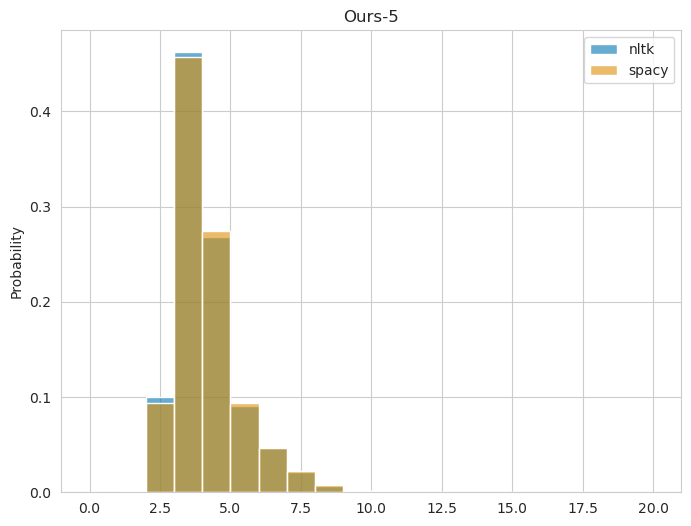

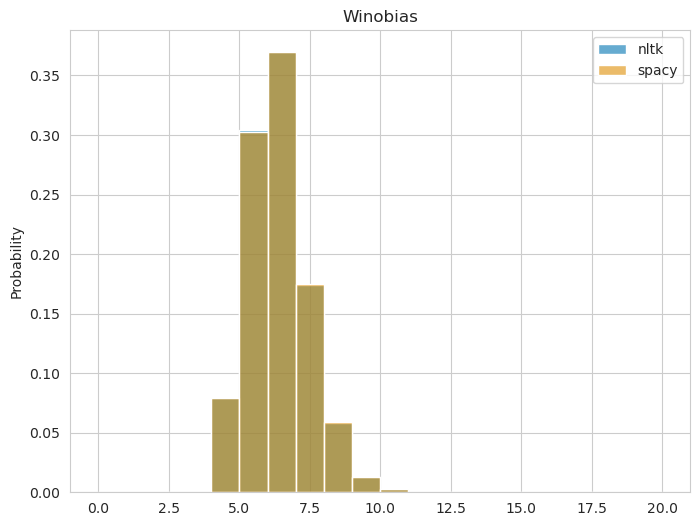

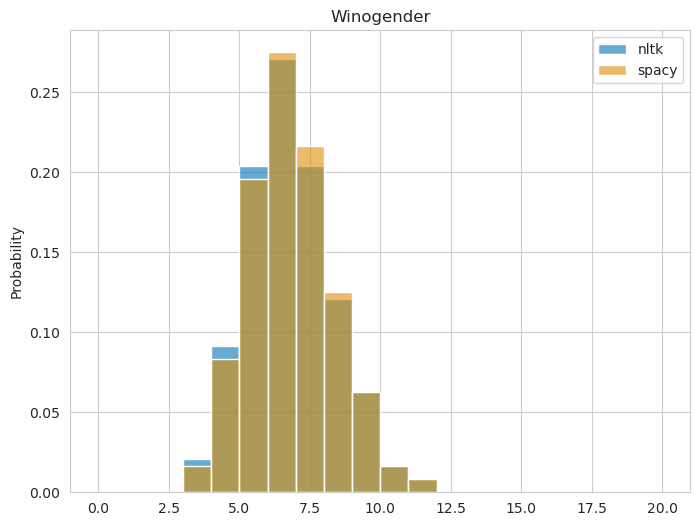

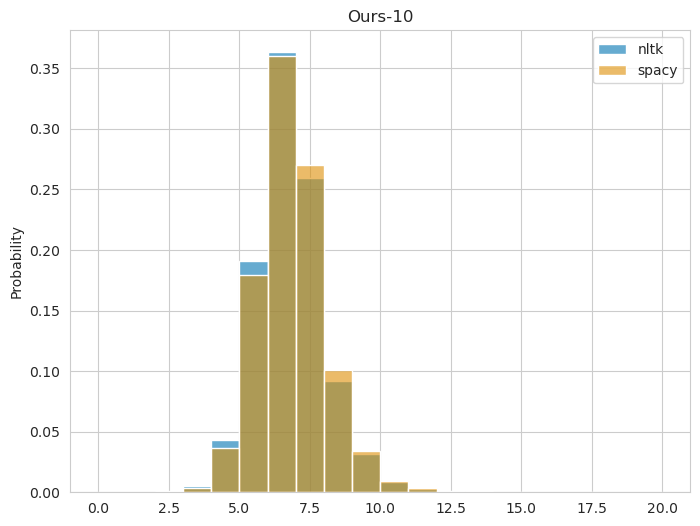

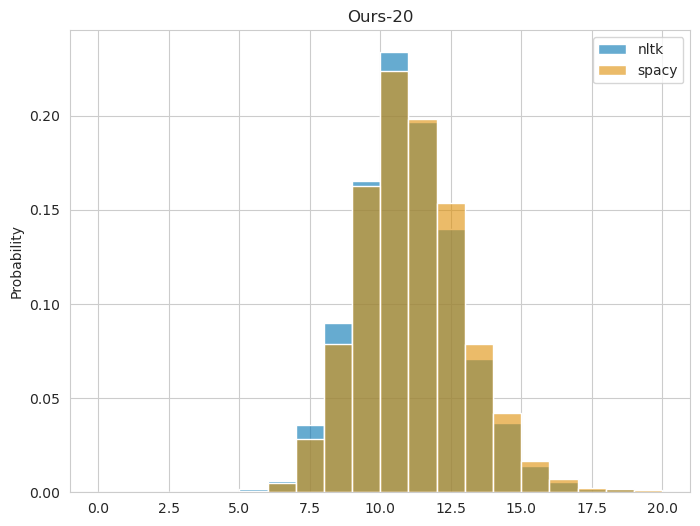

In [12]:
def compute_pmi_diff_per_sentences(
        templates: List[List[str]],
        word2pmi: dict,
        word2weights: dict,
    ) -> List[List[float]]:
    """Computes the PMI difference per individual token in the provided sentences.
    
    Notes
    -----
    It assumes the templates/sentences are already provided as a list of tokens.
    It returns two lists: the first one contains the list of pmi values for each of
    the provided words (some tokens won't have a PMI value associated); the second
    list contains the 1-1 mapping from word to pmi value and their weights.
    """
    pmi_values = []
    words_with_pmi = []
    
    for template in templates:
        pmi = np.array([word2weights[w] * word2pmi.get(w) for w in template if word2pmi.get(w) is not None])
        pmiwords = [{
            "word": w, 
            "pmi": round(word2pmi.get(w), 2),
            "weight": round(word2weights[w], 2),
        } for w in template if word2pmi.get(w) is not None]
        
        pmi_values.append(pmi)
        words_with_pmi.append(pmiwords)
            
    return pmi_values, words_with_pmi
        

    
    
PMI_PER_SENTENCES_NLTK = {dataset: 
                          compute_pmi_diff_per_sentences(templates, WORD2PMI, WORD2WEIGHTS)
                          for dataset, templates in DATASET_2_CANONIC_TEMPLATES_NLTK.items()
}

PMI_PER_SENTENCES_SPACY = {dataset: 
                          compute_pmi_diff_per_sentences(templates, WORD2PMI, WORD2WEIGHTS)
                          for dataset, templates in DATASET_2_CANONIC_TEMPLATES_SPACY.items()
}

# plot distribution
for dataset in DATASET_NAMES:
    # Compute the number of well-defined tokens with each of the approaches
    nltk_len = list(map(len, PMI_PER_SENTENCES_NLTK[dataset][0]))
    spacy_len = list(map(len, PMI_PER_SENTENCES_SPACY[dataset][0]))
    
    plt.figure(figsize=(8, 6))
    plt.title(dataset)
    sns.histplot(list(nltk_len), label="nltk", stat="probability", alpha=0.6, binrange=(0,20), binwidth=1)
    sns.histplot(list(spacy_len), label="spacy", stat="probability", alpha=0.6, binrange=(0,20), binwidth=1)
    plt.legend()
    plt.show()

Since in general **spacy** tokenizer leads to higher pct of examples being matched with a word. We will use the **spacy** tokenized templates to conduct the analysis (it increases the coverage of the constraints).

In [13]:
PMI_PER_TEMPLATES = {}
PMIWORDS_PER_TEMPLATES = {}

# Change the PMI_PER_SENTENCES_SPACY with PMI_PER_SENTENCES_NLTK
# to use NLTK tokenization instead.
for dataset, pmi_per_sents_values in PMI_PER_SENTENCES_NLTK.items():
# for dataset, pmi_per_sents_values in PMI_PER_SENTENCES_SPACY.items():
    pmi_vals, words_per_pmi = pmi_per_sents_values
    
    PMI_PER_TEMPLATES[dataset] = pmi_vals
    PMIWORDS_PER_TEMPLATES[dataset] = words_per_pmi

### Compute the constraint: MaxGenderPMI(s)

In this section, we compute the max gender PMI value per sentence. 

In [20]:
MAXGENDER_COL = "max_gender_pmi"

def max_gender_pmi(templates_pmi: List[List[str]], col: str) -> List[dict]:
    """Compute the maximum PMI diff per sentence."""
    def _max_pmi(lst_pmis: List[str]) -> float:
        if len(lst_pmis) > 0:
            idx = np.argmax(np.abs(lst_pmis))
            return lst_pmis[idx]
    
    results = []
    for template_pmi in templates_pmi:
        max_val = _max_pmi(template_pmi)
        results.append({col: max_val, f"{col}_invalid": max_val is None, "template_words_pmi": template_pmi})
        
    return results

In [21]:
# Contains the max gender pmi values per sentence
MAX_GENDER_PMI = {dataset: max_gender_pmi(templates_pmi, MAXGENDER_COL) 
                  for dataset, templates_pmi in PMI_PER_TEMPLATES.items()}

MAX_GENDER_PMI_LONG = []
for dataset, lst_value_dicts in MAX_GENDER_PMI.items():
    for value_dict in lst_value_dicts:
        r = {k: v for k, v in value_dict.items()}
        r["dataset"] = dataset
        MAX_GENDER_PMI_LONG.append(r)

MAX_GENDER_PMI_LONG = pd.DataFrame(MAX_GENDER_PMI_LONG)
        
# Adds the information to the original dataset with all models
# originally, preserved in the variable DATASET_2_FILES
DATASET_W_CONSTRAINTS = {dataset: pd.DataFrame(values * NUM_EVAL_MODELS)
                  for dataset, values in MAX_GENDER_PMI.items()}

# ------------------------------------------------------------------------------
# 
#                        Dataset w/ MaxGender PMI constraint!
# 
# ------------------------------------------------------------------------------
DATASET_W_CONSTRAINTS = {
    dataset: pd.concat((DATASET_2_FILES[dataset], DATASET_W_CONSTRAINTS[dataset]), copy=True, axis=1)
    for dataset in DATASET_NAMES
}

DATASET_W_CONSTRAINTS[DATASET_NAMES[0]].columns

Index(['orig_index', 'word', 'target_word', 'sentence', 'has_placeholder',
       'template', 'modifications', 'likely_under', 'is_natural', 'has_word',
       'is_revised', 'M_num_tokens', 'M_logprob', 'M_template', 'F_num_tokens',
       'F_logprob', 'F_template', 'FM_logprob', 'model', 'dataset',
       'is_deduped', 'is_gender_swap', 'intervention_type', 'step',
       'is_intervention', 'orig_model_name', 'model_size', 'model_family',
       'max_gender_pmi', 'max_gender_pmi_invalid', 'template_words_pmi'],
      dtype='object')

In [22]:
invalid_results = {dataset: df[df[f"{MAXGENDER_COL}_invalid"]] for dataset, df in DATASET_W_CONSTRAINTS.items()}
invalid_results

{'Ours-5':        orig_index      word target_word                       sentence  \
 1017         1017  focussed          he  He was always laser-focussed.   
 5422         1017  focussed          he  He was always laser-focussed.   
 9827         1017  focussed          he  He was always laser-focussed.   
 14232        1017  focussed          he  He was always laser-focussed.   
 18637        1017  focussed          he  He was always laser-focussed.   
 23042        1017  focussed          he  He was always laser-focussed.   
 27447        1017  focussed          he  He was always laser-focussed.   
 31852        1017  focussed          he  He was always laser-focussed.   
 36257        1017  focussed          he  He was always laser-focussed.   
 40662        1017  focussed          he  He was always laser-focussed.   
 45067        1017  focussed          he  He was always laser-focussed.   
 49472        1017  focussed          he  He was always laser-focussed.   
 53877        1

In [23]:
# Keep only the sentences w/ valid constraints
DATASET_W_CONSTRAINTS = {d: df[~df[f"{MAXGENDER_COL}_invalid"]] for d, df in DATASET_W_CONSTRAINTS.items()}


In [24]:
MAX_GENDER_PMI_LONG[["dataset", MAXGENDER_COL]].groupby("dataset").describe().T[DATASET_NAMES].style.format('{:.2f}')

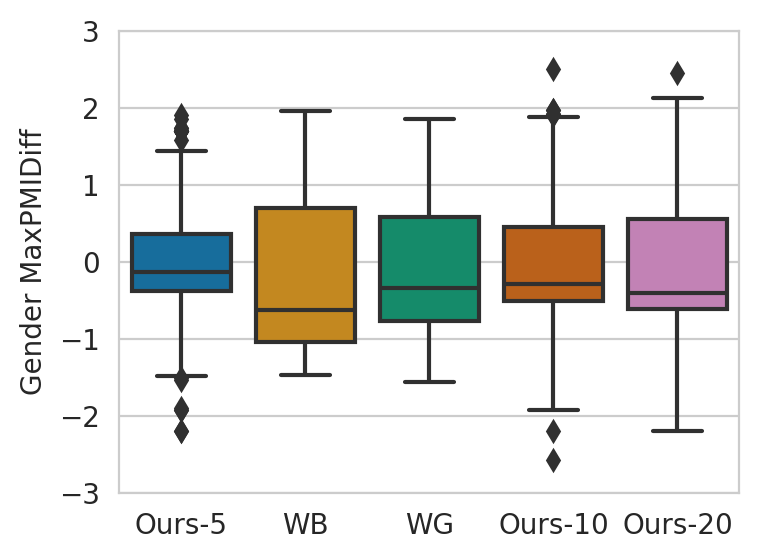

In [25]:
MAX_GENDER_PMI_LONG["dataset_"] = MAX_GENDER_PMI_LONG.dataset.apply(lambda x: "WB" if x == "Winobias" else ("WG" if x == "Winogender" else x))

plt.figure(figsize=(4, 3), dpi=200)
sns.boxplot(MAX_GENDER_PMI_LONG, x="dataset_", y=MAXGENDER_COL)
plt.ylim(-3, 3)
plt.ylabel("Gender MaxPMIDiff")
plt.xlabel(None)
plt.show()

In [26]:
num_templates = MAX_GENDER_PMI_LONG.groupby("dataset").count()[[MAXGENDER_COL]]
num_templates.rename({MAXGENDER_COL: "orig_num_templates"}, axis=1, inplace=True)
num_templates

,orig_num_templates
dataset,
Ours-10,4740
Ours-20,4839
Ours-5,4404
Winobias,1586
Winogender,240


## Data Analysis - Filtering using $\epsilon_k$

In this section, we observe how the number of templates changes as we increase the max gender pmi difference. We observe that little to no evaluation examples remain after enforcing smaller values of MaxGenderPMIDiff. Conversely, as we relax the constraint, more and more examples are included.

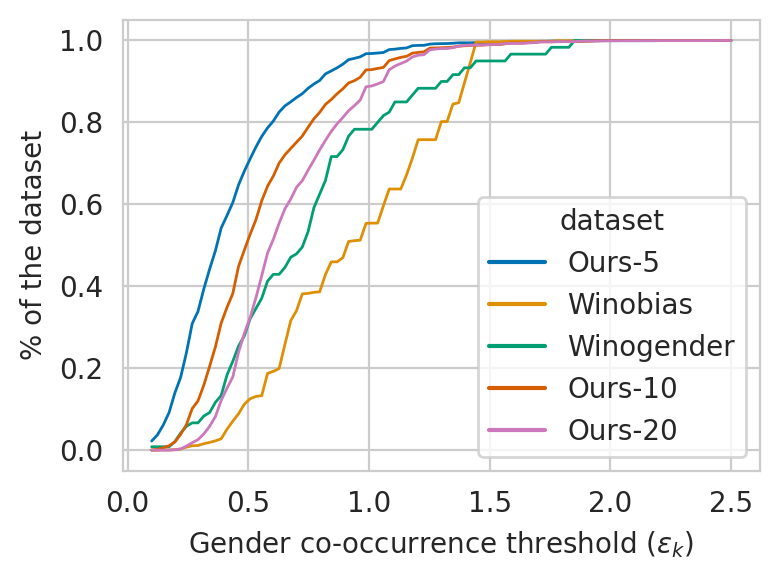

In [27]:
def filter_epsilon_k(
        data: dict,
        epsilons: List[float],
        col: str,
        constant: int=NUM_EVAL_MODELS,
    ) -> pd.DataFrame:
    results = defaultdict(list)
    
    dataset_max_counts = defaultdict(lambda: 0)
    for eps in epsilons:
        for dataset, df in data.items():
            counts = ((df[col] >= -eps) & (df[col] <= eps)).sum() / constant
            results["dataset"].append(dataset)
            results["filter"].append(eps)
            results["counts"].append(counts)
            
            if dataset_max_counts[dataset] < counts:
                dataset_max_counts[dataset] = counts
            
    results = pd.DataFrame(results)
    results["freq"] = results[["dataset", "counts"]].apply(lambda x: x["counts"]/(dataset_max_counts[x["dataset"]]), axis=1)
    
    return pd.DataFrame(results)


FILTERING_EPSILONS = np.linspace(0.10, 2.5, 101)[::-1]

FILTER_CURVES_RESULTS = filter_epsilon_k(
    DATASET_W_CONSTRAINTS,
    FILTERING_EPSILONS,
    MAXGENDER_COL,
    NUM_EVAL_MODELS)

plt.figure(figsize=(4,3), dpi=200)
sns.lineplot(FILTER_CURVES_RESULTS, x="filter", y="freq", hue="dataset", lw=1) #set y="counts" to plot absolute values instead
plt.xlabel("Gender co-occurrence threshold ($\epsilon_k$)")
plt.ylabel("% of the dataset")
#plt.legend( loc='upper left', bbox_to_anchor=(1, 1.01))
plt.tight_layout()
plt.show()

## Fairness metrics - Fixed threshold & AUC


In [51]:
FAIRNESS_COL = "FM_logprob"
FAIRNESS_THRESHOLD = 0.5
FAIRNESS_EPSILONS = np.linspace(0, 10, 101)
from sklearn.metrics import auc

def compute_neutralpct_fixed_threshold(dataset: pd.DataFrame, eps: float, col: str):
    abs_col = dataset[col].apply(np.abs)
    counts = (abs_col <= eps).sum()
    freq = counts / len(dataset)
    
    return counts, freq


def compute_neutralpct_auc(dataset: pd.DataFrame, epsilons: List[float], col: str):
    results = defaultdict(list)
    
    for eps in epsilons:
        counts, freq = compute_neutralpct_fixed_threshold(dataset, eps, col)
        results["fairness_eps"].append(eps)
        results["num_examples"].append(counts)
        results["pct_examples"].append(freq)
        
    results = pd.DataFrame(results)    
    return results, auc(results["fairness_eps"], results["pct_examples"])


def compute_neutralpct(data: dict, models: List[str], datasets: List[str], epsilons: List[float], col: str):
    results = []
    results_auc = defaultdict(list)

    for dataset in datasets:
        df = data[dataset].copy()
        
        for model in models:
            df_model = df[df["model"] == model].copy()
            out, out_auc = compute_neutralpct_auc(df_model, epsilons, col)
            
            out["model"] = model
            out["is_gender_swap"] = is_intervention(model)
            out["step"] = get_model_step(model)
            out["dataset"] = dataset
            results.append(out)
            
            results_auc["dataset"].append(dataset)
            results_auc["model"].append(model)
            results_auc["is_gender_swap"].append(is_intervention(model))
            results_auc["step"].append(get_model_step(model))
            results_auc["auc"].append(out_auc)
            
            
    return pd.concat(results), pd.DataFrame(results_auc)

In [52]:
FAIR_THRESHOLDS, FAIR_AUC = compute_neutralpct(DATASET_W_CONSTRAINTS, MODELS, DATASET_NAMES, FAIRNESS_EPSILONS, FAIRNESS_COL)

Text(0, 0.5, 'Area under the fairness curve ($\\epsilon_f \\in [0, 10]$)')

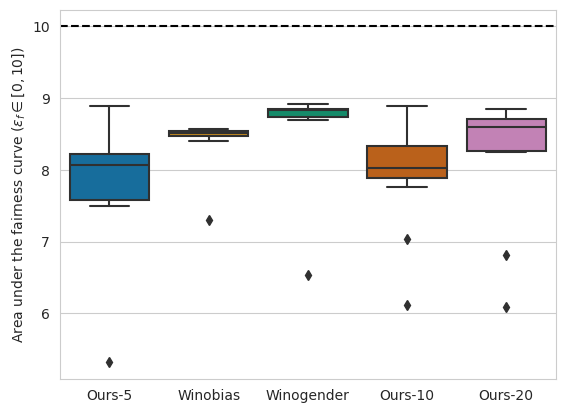

In [53]:
sns.boxplot(FAIR_AUC, x="dataset", y="auc")
plt.axhline(10, ls="--", color="black", label="max auc")
plt.xlabel(None)
plt.ylabel("Area under the fairness curve ($\epsilon_f \in [0, 10]$)")

<AxesSubplot: xlabel='step', ylabel='auc'>

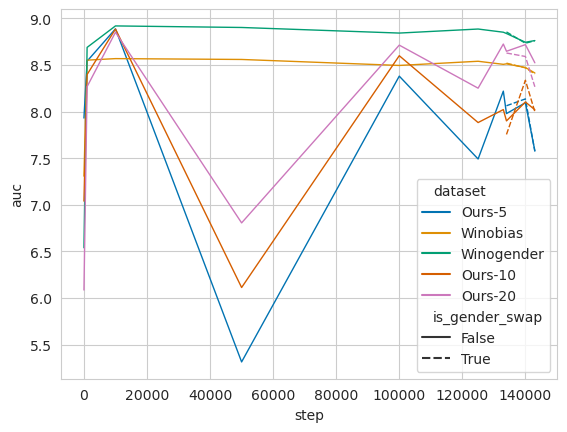

In [54]:
sns.lineplot(FAIR_AUC, x="step", y="auc", hue="dataset", style="is_gender_swap", lw=1)

### Fairness AUC table

In [55]:
FAIR_AUC["dataset_"] = FAIR_AUC["dataset"].apply(lambda x: x if x != "Ours-5" else "Ours-05")
pd.pivot_table(FAIR_AUC, index="model", values=["auc"], columns=["dataset_"]).style.format('{:.2f}')

In [56]:
def fairness_threshold_plots(fairthresholds, fairauc, datasetnames, models):
    for dataset in datasetnames:
        ft_df = fairthresholds[fairthresholds["dataset"] == dataset]
        ft_df = ft_df[ft_df["model"].isin(models)]


        aucs = fairauc[(fairauc["dataset"] == dataset) & (fairauc["model"].isin(models))]

        ft_df["is_deduplicated"] = ft_df["model"].apply(lambda x: "(D)" in x)
        ft_df["model"] = ft_df["model"].apply(lambda x: x.replace(" (D)", ""))
        print(aucs)
        plt.figure(figsize=(4,3), dpi=200)
        sns.lineplot(ft_df, x="fairness_eps", y="pct_examples", hue="model", style="is_deduplicated", lw=1)
        plt.axvline(FAIRNESS_THRESHOLD, color="gray", alpha=0.5)
        plt.tight_layout()
        plt.title(dataset)
        plt.xlabel("fairness threshold ($\epsilon_f$)")
        plt.ylabel("fairness metric ($\\tau$)")

        plt.show()

### AuFC: Pythia models

In [57]:
MODELS

['pythia-6.9b (D)__step0',
 'pythia-6.9b (D)__step1000',
 'pythia-6.9b (D)__step10000',
 'pythia-6.9b (D)__step100000',
 'pythia-6.9b (D)__step125000',
 'pythia-6.9b (D)__step133000',
 'pythia-6.9b (D)__step134000',
 'pythia-6.9b (D)__step140000',
 'pythia-6.9b (D)__step143000',
 'pythia-6.9b (D)__step50000',
 'pythia-intervention-6.9b (D)__step134000',
 'pythia-intervention-6.9b (D)__step140000',
 'pythia-intervention-6.9b (D)__step143000']

   dataset                                     model  is_gender_swap    step  \
8   Ours-5               pythia-6.9b (D)__step143000           False  143000   
12  Ours-5  pythia-intervention-6.9b (D)__step143000            True  143000   

         auc dataset_  
8   7.579927  Ours-05  
12  7.573467  Ours-05  


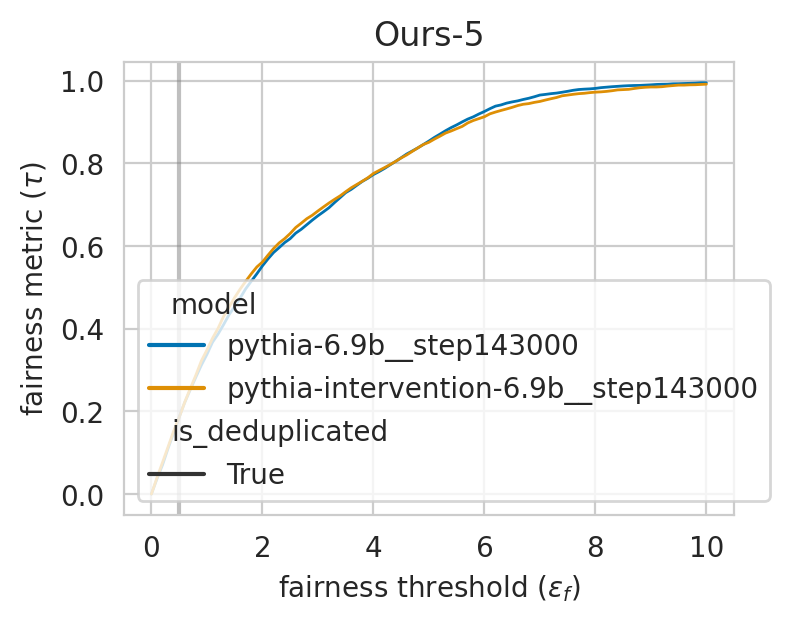

     dataset                                     model  is_gender_swap  \
21  Winobias               pythia-6.9b (D)__step143000           False   
25  Winobias  pythia-intervention-6.9b (D)__step143000            True   

      step       auc  dataset_  
21  143000  8.415195  Winobias  
25  143000  8.404666  Winobias  


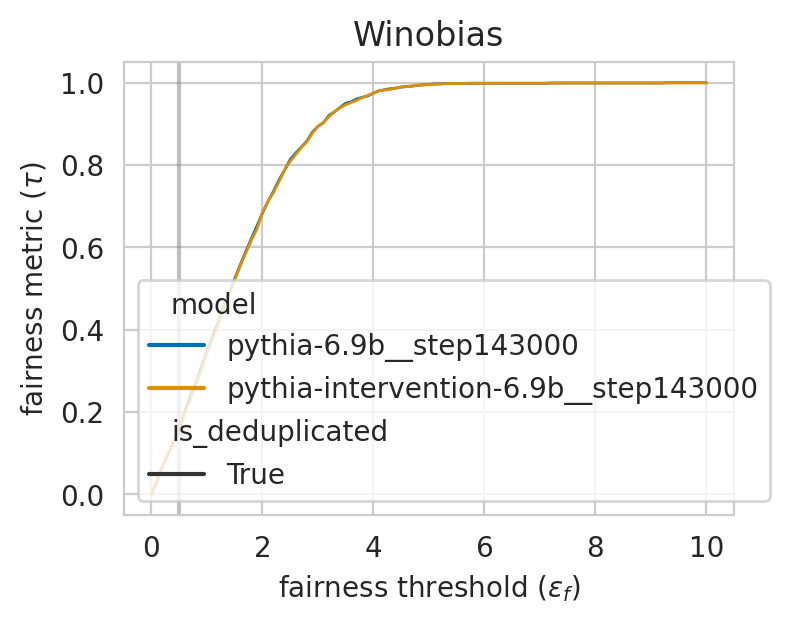

       dataset                                     model  is_gender_swap  \
34  Winogender               pythia-6.9b (D)__step143000           False   
38  Winogender  pythia-intervention-6.9b (D)__step143000            True   

      step       auc    dataset_  
34  143000  8.762917  Winogender  
38  143000  8.761667  Winogender  


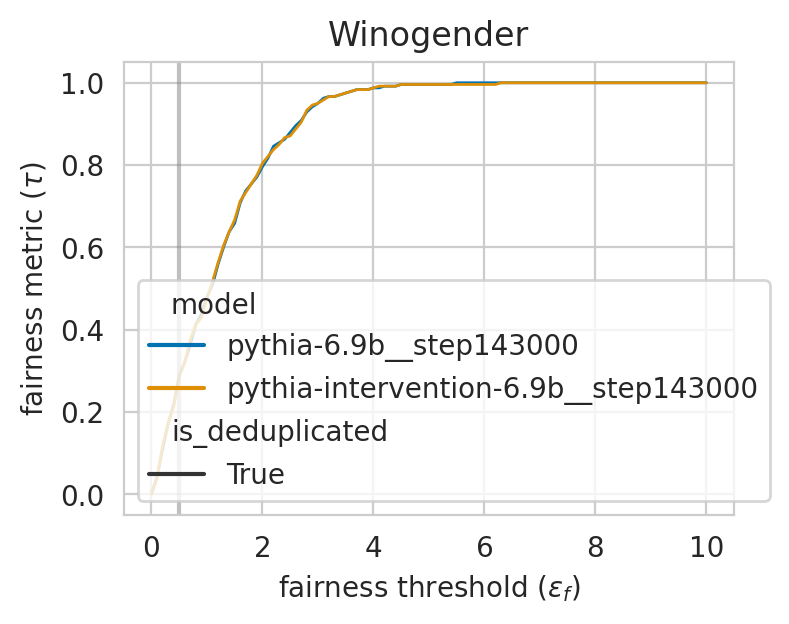

    dataset                                     model  is_gender_swap    step  \
47  Ours-10               pythia-6.9b (D)__step143000           False  143000   
51  Ours-10  pythia-intervention-6.9b (D)__step143000            True  143000   

         auc dataset_  
47  8.020443  Ours-10  
51  7.998523  Ours-10  


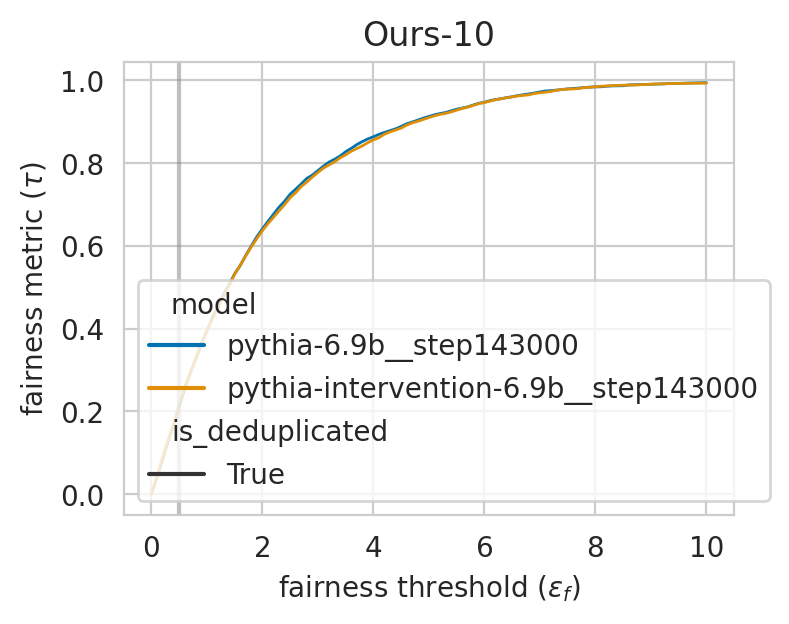

    dataset                                     model  is_gender_swap    step  \
60  Ours-20               pythia-6.9b (D)__step143000           False  143000   
64  Ours-20  pythia-intervention-6.9b (D)__step143000            True  143000   

         auc dataset_  
60  8.524292  Ours-20  
64  8.267059  Ours-20  


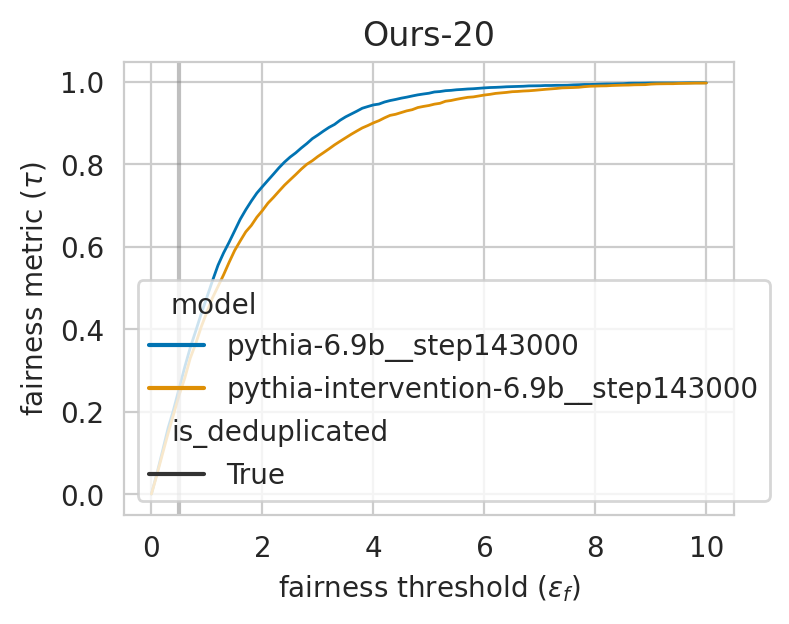

In [60]:
pythia_models = [
    'pythia-6.9b (D)__step143000',
    'pythia-intervention-6.9b (D)__step143000',
]

fairness_threshold_plots(FAIR_THRESHOLDS, FAIR_AUC, DATASET_NAMES, pythia_models)

## Fairness Neutrality

In this section, we aim to compute the different skews of the models for various constrained settings. 

In particular, we will compute:

1. Fairness metric: focus on the computation of the neutral examples, i.e., the examples whose test sentence pair likelihoods are within $\exp^{\epsilon_f}$
2. Difference in predicted female vs predicted male: if the sentences are not being predicted neutral, how is the model assigning the probability? 

In [61]:
FAIRNESS_THRESHOLD = 0.5
PMI_THRESHOLDS = [0.5, 0.65, 0.8, 1.0]

def filter_data_by_col_val(data: pd.DataFrame, col: str, thres: float):
    return data[(data[col] >= -thres) & (data[col] <= thres)]


# Compute the constrained version of the file
BEFORE_FILTER = {dataset: df.copy() for dataset, df in DATASET_W_CONSTRAINTS.items()}
AFTER_FILTER = {}

# Filter out the dataset_w_constraints according to the different PMI thresholds (or \epsilon_k)
for pmi_threshold in PMI_THRESHOLDS:
    AFTER_FILTER[pmi_threshold] = {
        dataset: filter_data_by_col_val(df, col=MAXGENDER_COL, thres=pmi_threshold).copy()
        for dataset, df in BEFORE_FILTER.items()
    } 

In [62]:
import glob, operator


def is_neutral(df, col=FAIRNESS_COL, threshold: float=FAIRNESS_THRESHOLD):
    assert 0 <= threshold <= 1
    assert col in df.columns
    return (df[col] >= -threshold) & (df[col] <= threshold)


def get_skew(df, col=FAIRNESS_COL, threshold: float=FAIRNESS_THRESHOLD):
    assert 0 <= threshold <= 1
    assert col in df.columns

    df = df.copy()
    df["skew"] = ["neutral"] * len(df)
    df.loc[df[col] < -threshold, "skew"] = "male"
    df.loc[df[col] >  threshold, "skew"] = "female"
    return df["skew"]


def get_bins(val, max_val=100, edges=(15, 10, 5, 2.5, 1, FAIRNESS_THRESHOLD)):
    __base_interval = pd.Interval(-edges[-1], edges[-1], closed="both")
    sign = np.sign(val)
    threshold = edges[-1]

    if sign == 0 or  -threshold <= val <= threshold:
        return __base_interval

    op = operator.gt if sign > 0 else operator.le
    edges = [sign * max_val] + [e * sign for e in edges]


    for i in range(1, len(edges)):
        if op(val, edges[i]):
            e1, e2 = edges[i-1], edges[i]
            bins = (e1, e2) if sign < 0 else (e2, e1)
            return pd.Interval(*bins, closed="neither" if sign < 0 and bins[-1] == -threshold else "right")
        
        
        
def compute_skews_(data_files: dict, fairness_col, fairness_threshold):
    # Note: This cell is going to add columns to the original dataframes in DATASET_2_FILES
    for name, df in data_files.items():
        get_fair_bins = lambda x: get_bins(val=x, max_val=100, edges=(15, 10, 5, 2.5, 1, fairness_threshold))
        df[f"{fairness_col}_bins"] = df[fairness_col].apply(get_fair_bins)

        df["is_neutral"] = is_neutral(df, fairness_col, fairness_threshold)
        # Obtain a discrete measure of what gender does the model fairness_col, skews
        # note: it assumes that positive values of fairness col will skew female
        # completions; and negative values skew male completions...
        df["skew"] = get_skew(df, fairness_col, fairness_threshold)
        
    return data_files


BEFORE_FILTER = compute_skews_(BEFORE_FILTER, FAIRNESS_COL, FAIRNESS_THRESHOLD)

AFTER_FILTER = {
    filt: compute_skews_(bias_files, FAIRNESS_COL, FAIRNESS_THRESHOLD) for filt, bias_files in AFTER_FILTER.items()
}

### Neutrality and AuFC (per constrained setting)

In [63]:
def compute_neutral_pct_w_std(data2files: dict):
    results = defaultdict(list)
    for dataset, df in data2files.items():
        neutral_mean = df[["model", "is_neutral"]].groupby("model").mean()
        neutral_mean *= 100

        # computed as the variance of a bernoulli distribution
        Y = neutral_mean

        n = len(BEFORE_FILTER["Ours-5"]) / NUM_EVAL_MODELS
        neutral_std = np.sqrt(Y/100 * (1 - Y/100) / n) * 100
        # neutral_std = BEFORE_FILTER["Ours-5"][["model", "is_neutral"]].groupby("model").std()

        results["dataset"].extend([dataset if dataset != "Ours-5" else "Ours-05"] * len(neutral_mean))
        results["model"].extend(neutral_mean.reset_index()["model"])
        results["neutral_avg"].extend(neutral_mean["is_neutral"].values.tolist())
        results["neutral_std"].extend(neutral_std["is_neutral"].tolist())
        final_repr = "$" + neutral_mean["is_neutral"].map('{:.2f}'.format) + "_{\\pm " + neutral_std["is_neutral"].round(2).map('{:.2f}'.format) + "}$"

        results["neutral_final"].extend(final_repr.values.tolist())
        
    return pd.DataFrame(results)
        
    
def compute_female_male_skews(data2files: dict, model_names=MODELS):
    results = defaultdict(list)
    for dataset, df in data2files.items():
        pcts = df.groupby(["model", "skew"]).count()["template"]
        
        for model in model_names:
            model_res = pcts[model]
            model_total = model_res.sum()
            
            results["dataset"].append(dataset if dataset != "Ours-5" else "Ours-05")
            results["model"].append(model)
            results["total"].append(model_total)
            results["pct_fem"].append(model_res.get("female", 0) / model_total * 100)
            results["pct_mal"].append(model_res.get("male", 0) / model_total * 100)
            
            pct_diff = round((model_res.get("female",0) - model_res.get("male", 0)) / model_total * 100, 2)
            results["pct_fem_min_mal"].append(f"{pct_diff:.2f}")
           
    return pd.DataFrame(results).round(2)


def merge_results(data2files) -> pd.DataFrame:
    return pd.merge(
        compute_neutral_pct_w_std(data2files),
        compute_female_male_skews(data2files),
        on=["dataset", "model"],
        how="inner"
    )


In [65]:
METRICS_BEFORE_FILTER = merge_results(BEFORE_FILTER)
METRICS_AFTER_FILTER = {eps: merge_results(AFTER_FILTER[eps]) for eps in AFTER_FILTER.keys()}

In [66]:
METRICS_AFTER_FILTER[0.5]

,dataset,model,neutral_avg,neutral_std,neutral_final,total,pct_fem,pct_mal,pct_fem_min_mal
0,Ours-05,pythia-6.9b (D)__step0,15.442133,0.544511,$15.44_{\pm 0.54}$,3076,49.15,35.40,13.75
1,Ours-05,pythia-6.9b (D)__step1000,21.163849,0.615512,$21.16_{\pm 0.62}$,3076,12.22,66.61,-54.39
2,Ours-05,pythia-6.9b (D)__step10000,24.902471,0.651644,$24.90_{\pm 0.65}$,3076,6.14,68.95,-62.81
3,Ours-05,pythia-6.9b (D)__step100000,14.661899,0.533019,$14.66_{\pm 0.53}$,3076,6.21,79.13,-72.92
4,Ours-05,pythia-6.9b (D)__step125000,18.888166,0.589812,$18.89_{\pm 0.59}$,3076,51.37,29.75,21.62
...,...,...,...,...,...,...,...,...,...
60,Ours-20,pythia-6.9b (D)__step143000,24.897959,0.651605,$24.90_{\pm 0.65}$,1470,47.41,27.69,19.73
61,Ours-20,pythia-6.9b (D)__step50000,20.680272,0.610302,$20.68_{\pm 0.61}$,1470,59.39,19.93,39.46
62,Ours-20,pythia-intervention-6.9b (D)__step134000,29.931973,0.690087,$29.93_{\pm 0.69}$,1470,37.82,32.24,5.58
63,Ours-20,pythia-intervention-6.9b (D)__step140000,28.027211,0.676785,$28.03_{\pm 0.68}$,1470,38.71,33.27,5.44


In [67]:
{dataset: len(df) / NUM_EVAL_MODELS for dataset, df in BEFORE_FILTER.items()}
{dataset: len(df) / NUM_EVAL_MODELS for dataset, df in AFTER_FILTER[0.5].items()}

#{dataset: len(df) / NUM_EVAL_MODELS for dataset, df in AFTER_FILTER[0.65].items()}
#{dataset: len(df) / NUM_EVAL_MODELS for dataset, df in AFTER_FILTER[0.80].items()}

{'Ours-5': 3076.0,
 'Winobias': 186.0,
 'Winogender': 69.0,
 'Ours-10': 2409.0,
 'Ours-20': 1470.0}

In [68]:
def model2latex(model: str):
    if "pythia" in model:
        return "\\" + re.sub(r"pythia-(.+)", r"pyths{\1}", model)
    elif "opt" in model:
        return "\\" + re.sub(r"opt-(.+)", r"opts{\1}", model)
    elif "mpt" in model:
        return "\\" + re.sub(r"mpt-(.+)", r"mpts{\1}", model)
    elif "llama-2" in model:
        return "\\" + re.sub(r"llama-2-(.+)", r"llamas{\1}", model)
    elif "gpt-j" in model:
        return "\\" + "gptj"
    else:
        raise ValueError(f"Unexpected: {model}")
        
        
def print_results(data, value):
    table = pd.pivot(data, values=[value], index="model", columns=["dataset"])
    table = table.droplevel(None, axis=1).rename_axis(None, axis=1).reset_index() 
    table["model"] = table["model"].apply(model2latex)
    print(table.set_index("model").to_latex())

    
def get_results(data, value):
    table = pd.pivot(data, values=[value], index="model", columns=["dataset"])
    table = table.droplevel(None, axis=1).rename_axis(None, axis=1).reset_index() 
    table["model"] = table["model"].apply(model2latex)
    return table.set_index("model")

### Neutral fairness

In [69]:
print("-" * 80, "\n")
print("NO FILTER")
print("\n", "-" * 80, "\n\n")
print_results(METRICS_BEFORE_FILTER, "neutral_final")



for eps, df in METRICS_AFTER_FILTER.items():
    print("-" * 80, "\n")
    print(f"FILTER = {eps}")
    print_results(METRICS_AFTER_FILTER[eps], "neutral_final")
    print("-" * 80, "\n\n")

-------------------------------------------------------------------------------- 

NO FILTER

 -------------------------------------------------------------------------------- 


\begin{tabular}{llllll}
\toprule
 & Ours-05 & Ours-10 & Ours-20 & Winobias & Winogender \\
model &  &  &  &  &  \\
\midrule
\pyths{6.9b (D)__step0} & $15.35_{\pm 0.54}$ & $11.18_{\pm 0.47}$ & $6.90_{\pm 0.38}$ & $13.49_{\pm 0.51}$ & $5.83_{\pm 0.35}$ \\
\pyths{6.9b (D)__step1000} & $21.14_{\pm 0.62}$ & $20.82_{\pm 0.61}$ & $19.84_{\pm 0.60}$ & $14.56_{\pm 0.53}$ & $18.75_{\pm 0.59}$ \\
\pyths{6.9b (D)__step10000} & $25.93_{\pm 0.66}$ & $28.46_{\pm 0.68}$ & $27.79_{\pm 0.68}$ & $19.17_{\pm 0.59}$ & $30.42_{\pm 0.69}$ \\
\pyths{6.9b (D)__step100000} & $14.90_{\pm 0.54}$ & $20.08_{\pm 0.60}$ & $27.59_{\pm 0.67}$ & $19.04_{\pm 0.59}$ & $30.00_{\pm 0.69}$ \\
\pyths{6.9b (D)__step125000} & $19.21_{\pm 0.59}$ & $22.00_{\pm 0.62}$ & $23.50_{\pm 0.64}$ & $19.42_{\pm 0.60}$ & $32.08_{\pm 0.70}$ \\
\pyths{6.9b (D)__step1

### pred female - pred male

In [70]:
get_results(METRICS_BEFORE_FILTER, "pct_fem_min_mal")
#get_results(METRICS_AFTER_FILTER[0.8], "pct_fem_min_mal")
#get_results(METRICS_AFTER_FILTER[0.65], "pct_fem_min_mal")
#get_results(METRICS_AFTER_FILTER[0.5], "pct_fem_min_mal")

,Ours-05,Ours-10,Ours-20,Winobias,Winogender
model,,,,,
\pyths{6.9b (D)__step0},17.12,50.42,67.10,43.25,84.17
\pyths{6.9b (D)__step1000},-53.88,-49.56,-45.86,-80.14,-73.75
\pyths{6.9b (D)__step10000},-59.36,-48.46,-32.57,-55.23,-46.25
\pyths{6.9b (D)__step100000},-70.48,-54.30,-34.55,-56.12,-45.00
\pyths{6.9b (D)__step125000},18.66,11.50,16.24,-52.71,-39.58
\pyths{6.9b (D)__step133000},-33.56,-15.72,-7.69,-56.94,-42.50
\pyths{6.9b (D)__step134000},-15.10,-12.70,3.20,-55.30,-41.67
\pyths{6.9b (D)__step140000},-36.26,-19.39,-14.88,-57.12,-46.67
\pyths{6.9b (D)__step143000},-8.63,22.05,14.18,-59.02,-46.25


In [71]:
print("-" * 80, "\n")
print("NO FILTER")
print("\n", "-" * 80, "\n\n")
print_results(METRICS_BEFORE_FILTER, "pct_fem_min_mal")



for eps, df in METRICS_AFTER_FILTER.items():
    print("-" * 80, "\n")
    print(f"FILTER = {eps}")
    print_results(METRICS_AFTER_FILTER[eps], "pct_fem_min_mal")
    print("-" * 80, "\n\n")

-------------------------------------------------------------------------------- 

NO FILTER

 -------------------------------------------------------------------------------- 


\begin{tabular}{llllll}
\toprule
 & Ours-05 & Ours-10 & Ours-20 & Winobias & Winogender \\
model &  &  &  &  &  \\
\midrule
\pyths{6.9b (D)__step0} & 17.12 & 50.42 & 67.10 & 43.25 & 84.17 \\
\pyths{6.9b (D)__step1000} & -53.88 & -49.56 & -45.86 & -80.14 & -73.75 \\
\pyths{6.9b (D)__step10000} & -59.36 & -48.46 & -32.57 & -55.23 & -46.25 \\
\pyths{6.9b (D)__step100000} & -70.48 & -54.30 & -34.55 & -56.12 & -45.00 \\
\pyths{6.9b (D)__step125000} & 18.66 & 11.50 & 16.24 & -52.71 & -39.58 \\
\pyths{6.9b (D)__step133000} & -33.56 & -15.72 & -7.69 & -56.94 & -42.50 \\
\pyths{6.9b (D)__step134000} & -15.10 & -12.70 & 3.20 & -55.30 & -41.67 \\
\pyths{6.9b (D)__step140000} & -36.26 & -19.39 & -14.88 & -57.12 & -46.67 \\
\pyths{6.9b (D)__step143000} & -8.63 & 22.05 & 14.18 & -59.02 & -46.25 \\
\pyths{6.9b (D)__step50000

### AuFC

In [72]:
for eps, df in AFTER_FILTER.items():
    print("-" * 80, "\n")
    print(f"FILTER = {eps}")
    print("-" * 80, "\n")
    FAIR_THRESHOLDS, FAIR_AUC = compute_neutralpct(df, MODELS, DATASET_NAMES, FAIRNESS_EPSILONS, FAIRNESS_COL)
    FAIR_AUC["dataset_"] = FAIR_AUC["dataset"].apply(lambda x: x if x != "Ours-5" else "Ours-05")
    print(pd.pivot_table(FAIR_AUC, index="model", values=["auc"], columns=["dataset_"]).style.format('{:.2f}').to_latex())
    

-------------------------------------------------------------------------------- 

FILTER = 0.5
-------------------------------------------------------------------------------- 

\begin{tabular}{lrrrrr}
 & \multicolumn{5}{r}{auc} \\
dataset_ & Ours-05 & Ours-10 & Ours-20 & Winobias & Winogender \\
model &  &  &  &  &  \\
pythia-6.9b (D)__step0 & 7.97 & 7.00 & 5.94 & 7.17 & 6.22 \\
pythia-6.9b (D)__step1000 & 8.55 & 8.43 & 8.23 & 8.55 & 8.71 \\
pythia-6.9b (D)__step10000 & 8.89 & 8.90 & 8.88 & 8.80 & 9.13 \\
pythia-6.9b (D)__step100000 & 8.39 & 8.67 & 8.80 & 8.85 & 9.05 \\
pythia-6.9b (D)__step125000 & 7.47 & 7.94 & 8.29 & 8.86 & 9.12 \\
pythia-6.9b (D)__step133000 & 8.22 & 8.08 & 8.79 & 8.81 & 9.07 \\
pythia-6.9b (D)__step134000 & 7.99 & 7.92 & 8.73 & 8.81 & 9.09 \\
pythia-6.9b (D)__step140000 & 8.10 & 8.16 & 8.80 & 8.79 & 9.01 \\
pythia-6.9b (D)__step143000 & 7.51 & 8.07 & 8.57 & 8.72 & 8.99 \\
pythia-6.9b (D)__step50000 & 5.18 & 6.10 & 6.64 & 8.79 & 9.04 \\
pythia-intervention-6.9b (

'\\begin{tabular}{lrrrrr}\n & \\multicolumn{5}{r}{auc} \\\\\ndataset_ & Ours-05 & Ours-10 & Ours-20 & Winobias & Winogender \\\\\nmodel &  &  &  &  &  \\\\\ngpt-j-6b & 9.20 & 9.03 & 8.95 & 8.81 & 9.05 \\\\\nllama-2-13B & 8.27 & 7.90 & 8.47 & 8.51 & 8.91 \\\\\nllama-2-7B & 8.48 & 7.60 & 8.54 & 8.51 & 9.10 \\\\\nmpt-30b & 4.69 & 5.30 & 5.57 & 8.42 & 8.92 \\\\\nmpt-7b & 8.11 & 8.06 & 8.13 & 8.50 & 8.91 \\\\\nopt-125m & 8.45 & 8.63 & 8.65 & 9.12 & 9.10 \\\\\nopt-2.7b & 9.02 & 9.04 & 9.03 & 8.80 & 8.96 \\\\\nopt-350m & 9.06 & 9.01 & 8.89 & 8.79 & 8.81 \\\\\nopt-6.7b & 9.04 & 9.08 & 9.04 & 8.65 & 8.94 \\\\\npythia-1.4b & 8.53 & 8.87 & 8.77 & 8.67 & 9.05 \\\\\npythia-1.4b (D) & 7.31 & 8.18 & 7.75 & 8.49 & 8.82 \\\\\npythia-12b & 8.96 & 8.84 & 8.64 & 8.74 & 8.95 \\\\\npythia-12b (D) & 8.59 & 8.55 & 8.41 & 8.64 & 9.03 \\\\\npythia-160m & 8.08 & 8.41 & 8.25 & 8.49 & 8.59 \\\\\npythia-160m (D) & 8.22 & 8.17 & 8.19 & 8.44 & 8.79 \\\\\npythia-2.8b & 8.27 & 8.32 & 8.25 & 8.82 & 9.18 \\\\\npythia-2.8

## Analysis

In [37]:
def get_analysis_examples(data2files, min_eps=0, max_eps=None):
    results = {}
    
    for dataset, df in data2files.items():
        if min_eps == 0 :
            mask = (df[MAXGENDER_COL].abs() >= min_eps)
        else:
            mask = (df[MAXGENDER_COL].abs() > min_eps)
        
        if max_eps is not None:
            mask &= (df[MAXGENDER_COL].abs() <= max_eps)
        
        try:
            results[dataset] = df[mask].groupby(["word", "target_word", "template", "skew"]).count()[["orig_index"]]
        except:
            results[dataset] = df[mask].groupby(["word", "template", "skew"]).count()[["orig_index"]]
        
        results[dataset].reset_index(inplace=True)
        results[dataset].rename({"orig_index": "model_votes"}, axis=1, inplace=True)    
    return results


EXAMPLES_050 = get_analysis_examples(AFTER_FILTER[0.5], 0, 0.5)
EXAMPLES_065 = get_analysis_examples(AFTER_FILTER[0.65], 0.5, 0.65)
EXAMPLES_1 = get_analysis_examples(AFTER_FILTER[1.00], 0.65, 1)
EXAMPLES_1plus = get_analysis_examples(BEFORE_FILTER, 1)

In [38]:
def get_sample(data2files, n=50, seed=98283):
    results = []
    for dataset, df in data2files.items():
        if not dataset.startswith("Wino"):
            # Get unique templates
            df_sampled = df.sort_values(["template", "model_votes"], ascending=False).groupby("template").head(1)
            # Get 50 random samples
            df_sampled = df_sampled.sample(n, random_state=seed, replace=False)
            df_sampled["dataset"] = dataset
        
            results.append(df_sampled)
        
    return pd.concat(results)

In [ ]:
get_sample(EXAMPLES_050).to_csv("./annotate_0_to_050_alldata_50each.csv")
get_sample(EXAMPLES_065).to_csv("./annotate_050_to_065_alldata_50each.csv")
get_sample(EXAMPLES_1).to_csv("./annotate_065_to_1_alldata_50each.csv")
get_sample(EXAMPLES_1plus).to_csv("./annotate_1plus_alldata_50each.csv")